# Week 47

In [1]:
try:
    import fysisk_biokemi
    print("Already installed")
except ImportError:
    %pip install -q "fysisk_biokemi[colab] @ git+https://github.com/au-mbg/fysisk-biokemi.git"

------------------------------------------------------------------------

## Determination of reaction orders.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#### (a) Load the dataset

Load the dataset `reaction_order_week48.xlsx` using the widget below

In [3]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [4]:
df = uploader.get_dataframe()
display(df)

In [5]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('reaction_order_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

#### (b) SI units.

Add two new columns with the concentrations given in M.

In [7]:
df['[A1]_(M)'] = df['[A1]_(uM)'] * 10**(-6)
df['[A2]_(M)'] = df['[A2]_(uM)'] * 10**(-6)
display(df)

#### (c) Plotting

For each reactant make a plot of

-   $t$ vs. $[\text{A}]$

> **Note**
>
> We will be adding more elements to the plot in the following parts of
> the exercise, therefore we will wrap the code for plotting in a
> function such that it can be easily reused.

The cell below defines the function for plotting, add the missing code
in places with `...`.

In [8]:
def plot_dataframe(ax, df):
    # Extract from dataframe
    t = df['Time_(s)']
    A1 = df['[A1]_(M)']
    A2 = df['[A2]_(M)']

    ax.plot(t, A1, 'o', label='[A1]')
    ... # Your code here to plot A2

    for ax in axes:
        ax.set_xlabel('t [s]')
        ax.legend()

In [9]:
def plot_dataframe(ax, df):
    # Extract from dataframe
    t = df['Time_(s)']
    A1 = df['[A1]_(M)']
    A2 = df['[A2]_(M)']

    # First subfigure: t vs [A]
    ax.plot(t, A1, 'o', label='[A1]')
    ax.plot(t, A2, 'o', label='[A2]')
    ax.set_xlabel('t [s]')
    ax.legend()

Once we’ve written the plotting function we can make the plot as done in
the cell below.

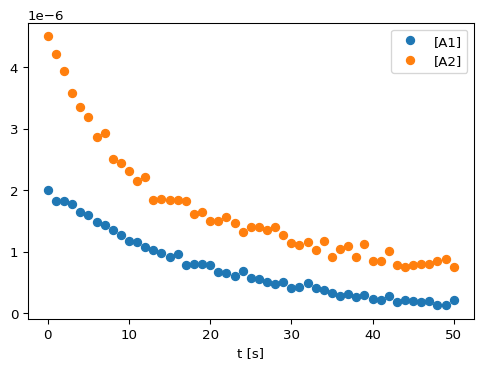

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plot_dataframe(ax, df)

#### (d) Determining reaction orders

Now we want to determine the reaction orders by making fits to the data
under the assumption of different integrated rate laws.

In the cell below finish the code to define functions for the integrated
rate laws of zeroth, first and second order.

In [13]:
def zeroth_order(t, k, A0):
    return A0 - k*t

def first_order(t, k, A0):
    return A0 * np.exp(-k*t)

def second_order(t, k, A0):
    return A0 / (1 + 2*k*t*A0)

rate_laws = {0: zeroth_order, 1: first_order, 2:second_order}

We can then use these to make fits, here it is helpful to define a small
function to help us with that.

In [14]:
from scipy.optimize import curve_fit

def make_fit(x_data, y_data, x_eval, A0, order):
    # Don't worry about this line for now. 
    # It just picks the correct function for the given order and sets A0.
    func = lambda t, k: rate_laws[order](t, k, A0)

    # Make fit
    popt, pcov = curve_fit(func, x_data, y_data)

    # Evaluate fit
    k = popt[0]
    y_fit = func(x_eval, k)
    return k, y_fit

Next we will define the known constants and extract a few things from
the `DataFrame`. In the cell below put the initial concentrations in M.

In [16]:
# Set the initial concentrations:
A1_0 = 2 * 10**(-6)
A2_0 = 4.5 * 10**(-6)

# Extract data
t = df['Time_(s)']
A1 = df['[A1]_(M)']
A2 = df['[A2]_(M)']
orders = [0, 1, 2]
t_eval = np.linspace(0, t.max()*1.1)

Now we can make and plot the fits

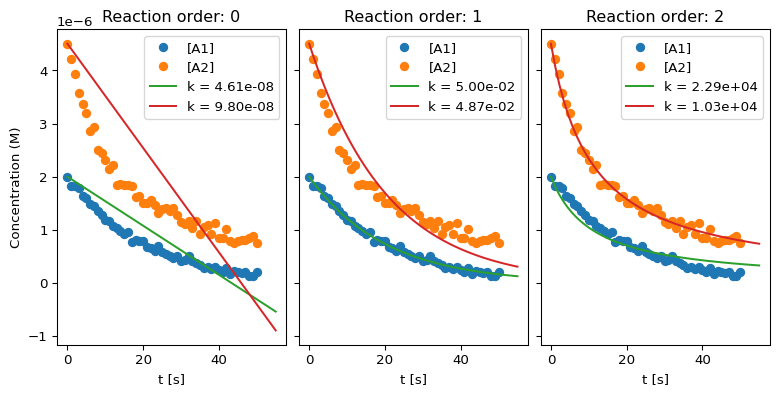

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharey=True, layout='constrained')

axes[0].set_ylabel('Concentration (M)')

for ax in axes:
    plot_dataframe(ax, df)

for ax, order in zip(axes, orders):
    k1, y_fit = make_fit(t, A1, t_eval, A1_0, order)
    ax.plot(t_eval, y_fit, color='C2', label=rf'k = {k1:.2e}')

    k2, y_fit = make_fit(t, A2, t_eval, A2_0, order)
    ax.plot(t_eval, y_fit, color='C3', label=rf'k = {k2:.2e}')
    ax.legend()
    ax.set_title(f'Reaction order: {order}')

Based on this plot;

-   What do you believe is the reaction order for \[A1\]?
-   What is the unit of the rate constant for \[A1\]?
-   What do you believe is the reaction order for \[A2\]?
-   What is the unit of the rate constant for \[A2\]?

> **Note**
>
> The cell above used a `for`-loop. These are a powerful way of
> performing the same operation with different inputs, you will learn
> more about them later on.

#### (e) Residuals

By inspecting the plot we can make a qualitative judgement of the
reaction orders. To get a more quantitative results we can look at the
residuals, recall they are defined as

$$
r_i = y_i - f(x_i | \theta)
$$

We can calculate these in much the same way we calculate the fits,
except we don’t evaluate the fit at a new set of points but at the
observations $x_i$.

In [20]:
def calculate_residuals(x_data, y_data, A0, order):
    # Don't worry about this line for now. 
    # It just picks the correct function for the given order and sets A0.
    func = lambda t, k: rate_laws[order](t, k, A0)

    # Make fit
    popt, pcov = curve_fit(func, x_data, y_data)

    # Evaluate fit
    k = popt[0]
    y_fit = func(x_data, k)
    residuals = y_data - y_fit
    return residuals

We can then plot the residuals, here using a histogram where the x-axis
is the value of the residual and the bars indicate the number of
residuals within that range of values.

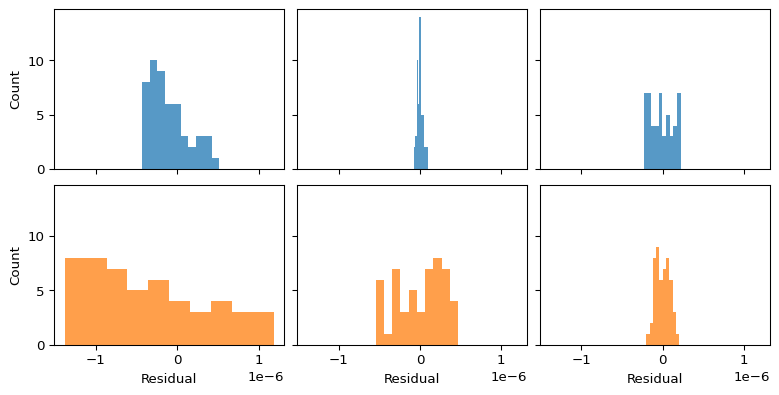

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4), sharey=True, layout='constrained', sharex=True)

axes[0, 0].set_ylabel('Count')
axes[1, 0].set_ylabel('Count')

for ax_col, order in zip(axes.T, orders):

    residuals = calculate_residuals(t, A1, A1_0, order)
    ax_col[0].hist(residuals, alpha=0.75, color='C0')

    residuals = calculate_residuals(t, A2, A2_0, order)
    ax_col[1].hist(residuals, alpha=0.75, color='C1')

    ax_col[1].set_xlabel('Residual')

Does this support your conclusions about the reaction order from (d)?

------------------------------------------------------------------------

## Analysis of a reversible reaction

In [23]:
import matplotlib.pyplot as plt
import numpy as np

Consider the following reaction

$$
A \underset{k_{2}}{\stackrel{k_1}{\rightleftharpoons}} B
$$

The magnitudes of the rate constants are $k_1 = 10 \ \mathrm{s}^{-1}$
and $k_2 = 1 \ \mathrm{s}^{-1}$.

#### (a) Reaction order

What is the reaction order in each direction?

#### (b) Derive equilibrium constant

Show mathematically how the equilibrium constant $K_{\mathrm{eq}}$ is
given by the ratio between the two rate constants.

#### (c) Calculate $K_{\mathrm{eq}}$

In [25]:
k1 = 10 
k2 = 1
K_eq = k1 / k2
print(f"{K_eq = }")

K_eq = 10.0

#### (d) Equilibrium concentrations

Calculate the concentrations of A and B at equilibrium,
$[\mathrm{A}]_{\mathrm{eq}}$ and $[\mathrm{B}]_\mathrm{eq}$, if
$[\mathrm{A}]_0 = 10^{-3} \text{M}$

In [27]:
A0 = 10**(-3)
A_eq = (k2 * A0) / (k1 + k2)
B_eq = (k1 * A0) / (k1 + k2)
print(f"{A_eq = }")
print(f"{B_eq = }")

A_eq = 9.090909090909092e-05
B_eq = 0.0009090909090909091

#### (e) Rates at equilibrium

Calculate the forward and reverse rates at equilibrium at this
concentration.

In [29]:
r_fwd = A_eq * k1
r_bwd = B_eq * k2 # Sanity check
print(f"{r_fwd = :.5f}")
print(f"{r_bwd = :.5f}")

r_fwd = 0.00091
r_bwd = 0.00091

#### (f) Initial rate of formation

If $[\mathrm{A}]_0 = 10^{-3} \text{M}$ and
$[\mathrm{B}]_0 = 0 \text{M}$, calculate the initial rate of formation
of B.

In [31]:
r_fwd = A0 * k1
print(f"{r_fwd = :.5f}")

r_fwd = 0.01000

#### (g) Time-dependence

![](https://raw.githubusercontent.com/au-mbg/fysisk-biokemi/refs/heads/main/lessons/figures/week_48/reversible_reaction.png)

We now want to calculate and plot the time-dependent concentrations
using the above equations.

In the cell below finish the implementation of the function `A_time`
that calculates the concentration \[A\] as a function of time.

In [33]:
def A_time(t, A0, k_f, k_b):
    return (k_b + k_f * np.exp(-(k_f+k_b)*t)) / (k_f + k_b) * A0

> **Caution**
>
> Be careful to correctly set parantheses when implementing this
> function!

And then we can use that function to calculate and plot the
concentrations as a function of time.

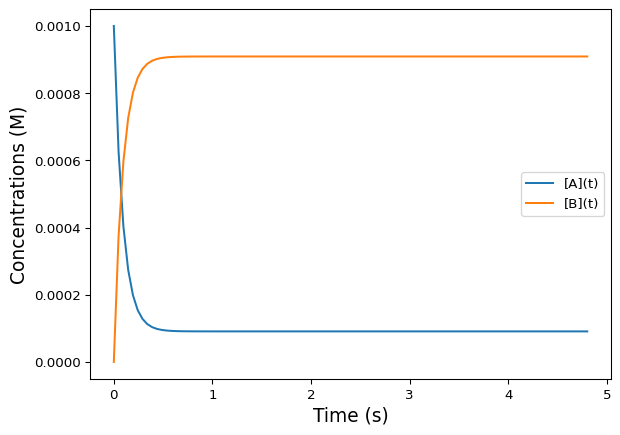

In [35]:
fig, ax = plt.subplots()

t_max = 0.08 * 60 # Time in seconds
t = np.linspace(0, t_max, 100)

At = A_time(t, A0, k1, k2)
Bt = A0 - At

ax.plot(t, At, label='[A](t)')
ax.plot(t, Bt, label='[B](t)')
ax.set_ylabel('Concentrations (M)', fontsize=14)
ax.set_xlabel('Time (s)', fontsize=14)
ax.legend()

------------------------------------------------------------------------

## Determination of reaction order and activation energy

In [36]:
import numpy as np  
import matplotlib.pyplot as plt

The irreversible isomerization of compound A to compound B results in a
decreasing absorbance. The isomerization was followed in a time course
at two different temperatures (T1 = 25 °C and T2 = 40 °C). The
absorbance ($\epsilon$ = 16700 $\mathrm{cm}^{-1} \mathrm{M}^{-1}$) was
used to calculate the concentration of compound A in a spectrophotometer
with a pathlength of 1 cm. The obtained dataset is given in the file
`week48_7_reaction_order_activation.csv`.

#### (a) Temperatures

What are the two temperatures in Kelvin? Set them as varilabes in the
cell below.

In [38]:
T1 = 25 + 273.15
T2 = 40 + 273.15

#### (b) Load the dataset

Load the dataset using the widget below

In [39]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [40]:
df = uploader.get_dataframe()
display(df)

In [41]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('reaction_order_activation_week48') # Load from package for the solution so it doesn't require to interact.
display(df)

#### (c) SI Units

Calculate the concentration of A at each timepoint in SI units, by
adding new columns to the `DataFrame`.

In [43]:
extinction_coeff = 16700 
L = 1 # Path length

df['[A]_(M)_25C'] = df['Abs(t)_25C'] / (extinction_coeff * L)
df['[A]_(M)_40C'] = df['Abs(t)_40C'] / (extinction_coeff * L)
display(df)

#### (d) Plot the data

We will be resuing the plot, so we will put the code for it in a
function.

In [45]:
def plot_dataframe(ax, df):
    # Extract from dataframe
    t = df['t_(s)']
    A_25 = df['[A]_(M)_25C']
    A_40 = df['[A]_(M)_40C']

    # First subfigure: t vs [A]
    ax.plot(t, A_25, 'o', label='[A]_25C')
    ax.plot(t, A_40, 'o', label='[A]_40C')
    ax.set_xlabel('t (s)')
    ax.set_ylabel('[A] (M)')
    ax.legend()

You can run this next cell to see your plot and adjust as neccesarry.

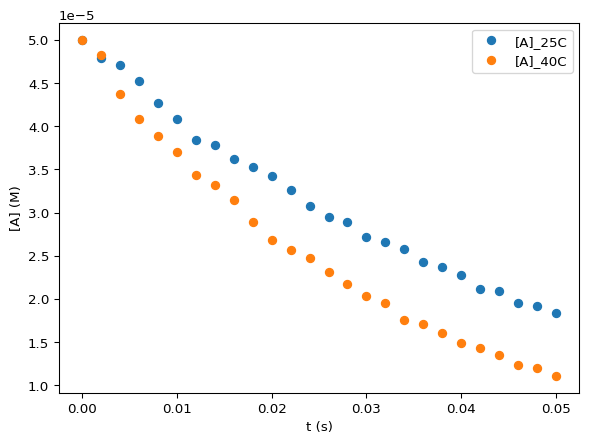

In [46]:
fig, ax = plt.subplots()
plot_dataframe(ax, df)

#### (e) Determine reaction order

In the exercise on “Determination of reaction orders” we saw how we can
fit to the expressions for the integrated rate laws to determine the
reaction order.

In that exercise we wrote the functions in the next two cells, we will
reuse them here

In [47]:
def zeroth_order(t, k, A0):
    return A0 - k*t

def first_order(t, k, A0):
    return A0 * np.exp(-k*t)

def second_order(t, k, A0):
    return A0 / (1 + 2*k*t*A0)

rate_laws = {0: zeroth_order, 1: first_order, 2:second_order}

In [48]:
from scipy.optimize import curve_fit

def make_fit(x_data, y_data, x_eval, A0, order):
    func = lambda t, k: rate_laws[order](t, k, A0)
    popt, pcov = curve_fit(func, x_data, y_data)

    # Evaluate fit at new points
    k = popt[0]
    y_fit_new = func(x_eval, k)
    
    # Evaluate fit at data-points to calculate residuals
    y_fit_data = func(x_data, k)
    residuals = y_data - y_fit_data

    return k, y_fit_new, residuals

Now we need to set a few things before we can do the fitting

In [50]:
t = df['t_(s)']
A_25 = df['[A]_(M)_25C']
A_40 = df['[A]_(M)_40C']
A0_25= A_25[0]
A0_40 = A_40[0]

> **Tip**
>
> You’ve already calculated the initial concentration, it is contained
> in the `DataFrame`.

Now we can use our plotting and fitting functions to analyze the data

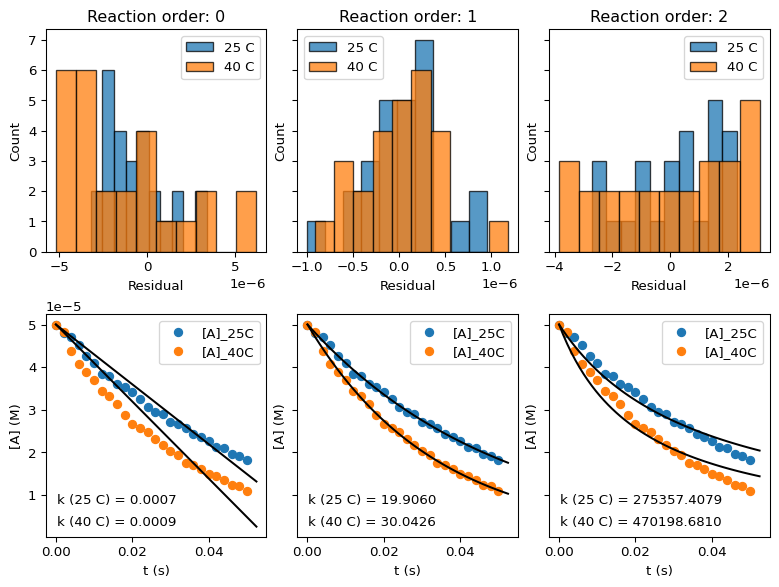

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharey='row', layout='constrained')

for ax in axes.T:
    plot_dataframe(ax[1], df)

orders = [0, 1, 2]
t_eval = np.linspace(0, t.max()*1.05)

for ax_col, order in zip(axes.T, orders):
    # Calculate the fits
    k25, y_fit_25, residuals_25 = make_fit(t, A_25, t_eval, A0_25, order)
    k40, y_fit_40, residuals_40 = make_fit(t, A_40, t_eval, A0_40, order)

    # Plot the fits
    ax = ax_col[1]
    ax.plot(t_eval, y_fit_25, color='k')
    ax.plot(t_eval, y_fit_40, color='k')
    ax.text(0.05, 0.15, f'k (25 C) = {k25:.4f}', transform=ax.transAxes)
    ax.text(0.05, 0.05, f'k (40 C) = {k40:.4f}', transform=ax.transAxes)

    ax.legend()

    # Plot the residuals
    ax = ax_col[0]
    ax.hist(residuals_25, facecolor='C0', alpha=0.75, edgecolor='k', label='25 C')
    ax.hist(residuals_40, facecolor='C1', alpha=0.75, edgecolor='k', label='40 C')
    ax.set_xlabel('Residual')    
    ax.set_ylabel('Count')
    ax.legend()

    ax.set_title(f'Reaction order: {order}')

Based on these plots

-   What do you think the reaction order of the reaction is?
-   What’s the rate constant?
-   What the unit of the rate constant?

#### (f) Half-life

What is the half-life of the reaction at these temperatures and is it
constant through-out the reaction?

#### (g) Activation energy

With the assumption that the Arrhenius constant A and the activation
energy are temperature independent in the interval measured, use the
Arrhenius equation to calculate the activation energy of the
isomerization of the compound A.

Perform the calculation in the cell below.

In [53]:
...

------------------------------------------------------------------------

## The pH effect on an active site histidine residue

Assume that a compound R can react with the unprotonated form of
Histidine, $\text{His}$, to form a covalent reaction product,
$\text{P}$: $$
\text{His} + \text{R} \rightarrow \text{P}
$$

The protonated form of Histidine, $\text{HisH}^+$, is in equilibrium
with $\text{His}$:

$$
\text{HisH}^+ \rightleftharpoons \text{His} + \text{H}^+
$$

The pKa value for this acid-base equilibrium is 6.0. Further assume that
the total concentration of Histidine, is

$$
[\text{HisH}^+] + [\text{His}] = 10^{-3} \ \text{M}
$$

#### (a) Percentage unprotonated

Using the Henderson-Hasselbach equation, calculate the percentage of
unprotonated Histidine, $\text{His}$, at pH 6.0.

In [55]:
pKa = 6.0
pH = 6.0
ratio = 10 ** (pH - pKa)
percentage_unprotonated = 1 / (1 + ratio) * 100
print(f"{percentage_unprotonated = } %")

percentage_unprotonated = 50.0 %

#### (b) Concentration

Calculate $[\text{His}]$ at pH 6

In [57]:
total_conc = 10**(-3)
his_conc = total_conc * percentage_unprotonated
print(f"{his_conc = } M")

his_conc = 0.05 M

#### (c) Reaction order

The reaction equation for the reaction between $\text{His}$ and
$\text{R}$ is

$$
v = - \frac{d[\text{His}]}{dt} = k \cdot [\text{His}] \cdot [\text{R}]
$$

What’s the reaction order?

#### (d) High concentrations

If $[\text{R}]$ is much higher than $[\text{His}]$, what can then be
concluded regarding the order of the reaction?

#### (e) New rate constant

Show how a new rate constant, $k'$, can be defined in these conditions.
How does $k'$ depend on $\text{R}$?

#### (f) SI Units

At pH 6.0 the reaction rate $v = 1 \ \text{mM}\cdot \text{s}^{-1}$ and
constant $[\text{R}] = 0.2 \ \text{M}$

Convert the reaction rate to SI-units given in
$\text{M}\cdot \text{s}^{-1}$.

In [58]:
...

#### (g) Calculate the rate constant

Use the concentration of $[\text{His}]$ at pH 6 calculated in question
(b) and calculate the rate constant k.

In [59]:
...

------------------------------------------------------------------------

## Design of an enzyme kinetics experiment (Unfinished)

In [60]:
import matplotlib.pyplot as plt

In the Excel document tø12_week49_data you will find a data set in which
an enzyme catalyzed formation of product P, with varying start
concentration of substrates, \[S\], was followed over time. The product
absorbs light at a specific wavelength with an extinction coefficient of
0.068 $\mu\text{M}^{-1}\cdot \text{cm}^{-1}$, and the absorbance was
measured in a light path of 1 cm throughout the time course.

You can load the dataset using the cells below;

In [61]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [62]:
df = uploader.get_dataframe()
display(df)

In [63]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('week49_1') # Load from package for the solution so it doesn't require to interact.
display(df)

The headers, like `Abs_S1` refer to the substrate concentration so `S1`
means a substrate concentration of 1 $\mu\text{M}$.

#### (a)

Convert the extinction coefficient to units given in
$\text{M}^{-1}\cdot \text{cm}^{-1}$ and assign it to a variable. Also
assign the light path length to a variable.

In [65]:
ext_coeff = 0.068 / 10**(-6) # 1/(M cm)
l = 1 # cm

#### (b) Calculate concentrations

Using Lambert-Beers law, calculate the concentration of product, \[P\],
in M for each time series.

> **Loops**
>
> Loops are one of the most useful parts of programming, loops allows us
> to repeat an operation on many different elements. This allows us to
> not have to repeat code many times, making it simpler to understand
> and less prone to error - and at the same time more flexible.
>
> A common type of loop in Python is the `for` loop, which does
> something `for` every item it is told to consider. The syntax of a
> `for`-loop is like so:
>
> ``` python
> total = 0
> for count in [1, 2, 3, 4, 5]:
>     print(f"I have {count} apples.")
> ```
>
> Which will print
>
>     I have 1 apples
>     I have 2 apples
>     I have 3 apples
>     I have 4 apples
>     I have 5 apples
>
> So the `for`-loop did the operation of printing a string for each
> value of `count`.
>
> When working with a `DataFrame` like in this exercise, we may for
> example want to do something `for` each column, one way of doing that
> is to loop over the column names, say we want we have a `DataFrame`
> `df` with columns named `"col1", "col2", "col3"` we can loop over that
> as
>
> ``` python
> for name in ['col1', 'col2', 'col3']
>     df[name] = ... # Some operation
> ```

The cell below setups a loop calculate the concentrations for each of
these current columns in the dataframe.

In [67]:
substrate_concentrations = [1, 3, 5, 7, 9, 11, 13, 15]
for s in substrate_concentrations:
    abs_col_name = f'Abs_S{s}' # This creates a string where the value of 's' is put instead of "{s}"".
    conc_col_name = f'C_S{s}' # Same type string creation 
    df[conc_col_name] = df[abs_col_name] / (ext_coeff * l)
    print(s, abs_col_name, conc_col_name)

1 Abs_S1 C_S1
3 Abs_S3 C_S3
5 Abs_S5 C_S5
7 Abs_S7 C_S7
9 Abs_S9 C_S9
11 Abs_S11 C_S11
13 Abs_S13 C_S13
15 Abs_S15 C_S15

And we can check that the columns we expect have been added to the
`DataFrame`.

In [69]:
display(df)

#### (c) Plot

Plot \[P\] as a function of time for all experiments in one single
graph.

Here it is again very useful to use a `for`-loop

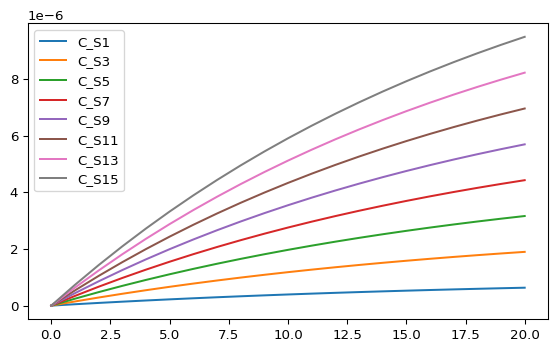

In [70]:
fig, ax = plt.subplots(figsize=(7, 4))

x_axis = df['time_(s)']
substrate_concentrations = [1, 3, 5, 7, 9, 11, 13, 15]
for s in substrate_concentrations:
    conc_col_name = f'C_S{s}'
    y_axis = df[conc_col_name]

    ax.plot(x_axis, y_axis, label=conc_col_name)

ax.legend()    

#### (d)

How could you use Excel to determine $V_0$ for each concentration of
$S$? Create a table of $V_0$ vs $[S]$

#### (e)

Why is it important to use $V_0$ rather than $V$ at a later time point
when creating the Michaelis-Menten plot?

#### (f)

Plot $V_0$ against substrate concentration and estimate $k_{cat}$ and
$K_M$ visually (remember units)

------------------------------------------------------------------------

## Analysis of a data set obeying Michaelis-Menten kinetics (Unfinished)

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
pd.set_option('display.max_rows', 6)

The kinetics for an enzyme were investigated using the absorbance of the
product to calculate the initial velocities for a range of different
initial concentrations of the substrate. The data given in the dataset
`week49_2.xlsx` was obtained. Use these data to answer the following
questions.

In [72]:
from fysisk_biokemi.widgets import DataUploader
from IPython.display import display 
uploader = DataUploader()
uploader.display()

Run the next cell **after** uploading the file

In [73]:
df = uploader.get_dataframe()
display(df)

In [74]:
from IPython.display import display 
from fysisk_biokemi.datasets import load_dataset
df = load_dataset('week49_2') # Load from package for the solution so it doesn't require to interact.
display(df)

39 rows × 2 columns

#### (a) SI Units

Convert the concentrations of substrate and the velocities to the SI
units $\text{M}$ and $\text{M}\cdot\text{s}^{-1}$, respectively.

In [76]:
df['[S]_(M)'] = df['[S]_(mM)'] * 10**(-3)
df['V0_(M/s)'] = df['V0_(uM/s)'] * 10**(-6)
display(df)

39 rows × 4 columns

#### (b) Plot & estimate

Plot the initial velocities, $V_0$, as a function of substrate
concentrations, $[S]$. Estimate $K_M$ and $V_\mathrm{max}$ from this
plot.

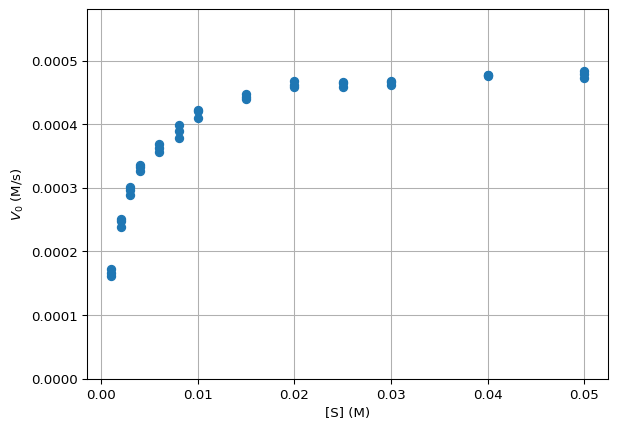

In [78]:
fig, ax = plt.subplots()
ax.plot(df['[S]_(M)'], df['V0_(M/s)'], 'o')
ax.set_xlabel('[S] (M)')
ax.set_ylabel('$V_0$ (M/s)')
ax.grid('on')
ax.set_ylim(0, df['V0_(M/s)'].max()*1.2)

#### (c) Fit

Now we want to fit using the Michaelis-Menten equation, as per usual
when the task is fitting we have to define the function we are fitting
with

In [80]:
def michaelis_menten(S, Vmax, Km):
    return (Vmax * S) / (Km + S)

> **Caution**
>
> This is one of those places were parentheses are crucial.

And then we can follow our usual procedure to make the fit

In [82]:
x_data = df['[S]_(M)']
y_data = df['V0_(M/s)']

popt, pcov = curve_fit(michaelis_menten, x_data, y_data)
Vmax, Km = popt

print(f"{Vmax = :.4f}")
print(f"{Km = :.4f}")

Vmax = 0.0005
Km = 0.0021

How do these values compare to your estimate?

#### (d) Enzyme concentration

The $k_{cat}$ of the enzyme was determined to be
$20000 \ \text{s}^{-1}$. Calculate, in the cell below, the concentration
of the enzyme used in the assay.

In [84]:
kcat = 20000
enzyme_concentration = Vmax / kcat 
print(f'Enzyme concentration: {enzyme_concentration:.3e} M')

Enzyme concentration: 2.504e-08 M